In [1]:
import torch
import scipy

import matplotlib.pyplot as plt
import numpy as np

from datetime import datetime, timedelta

from config import *
from data.ssa import SSA, SequentialSSA
from data.util import crop_q_between, extract_week_day, POINTS_PER_DAY

%matplotlib inline

%reload_ext autoreload
%autoreload 2

In [2]:
READ_START_DATE = datetime.strptime(CONFIG['READ_START_DATE'], DATE_FORMAT)
READ_END_DATE = datetime.strptime(CONFIG['READ_END_DATE'], DATE_FORMAT)

# One week Monday - Monday
PLOT_START_DATE = datetime(2021, 5, 7)
PLOT_END_DATE = PLOT_START_DATE + timedelta(days=7)

SECTION_INDEX = 9

In [3]:
fs = 100
time = torch.linspace(0, 3, fs * 3)

def gen_sin(freq, phi = 0.0):
    return torch.sin(2 * torch.pi * freq * time + phi)

sig_f1 = gen_sin(1)
sig_f2 = gen_sin(2, torch.pi / 2)
sig_f3 = gen_sin(3)
sig_f6_5 = gen_sin(6.5)

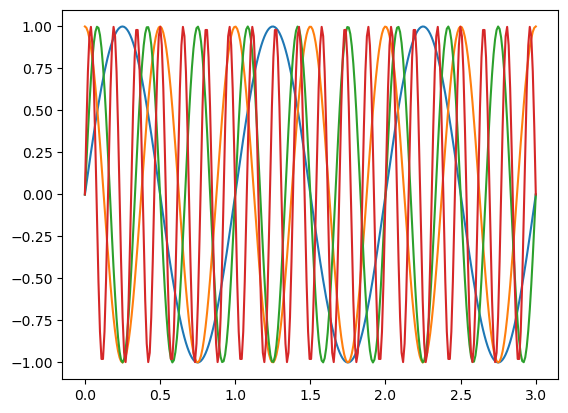

In [4]:
plt.plot(time, sig_f1)
plt.plot(time, sig_f2)
plt.plot(time, sig_f3)
plt.plot(time, sig_f6_5)
plt.show()

torch.Size([300]) torch.Size([300]) torch.Size([2, 300])


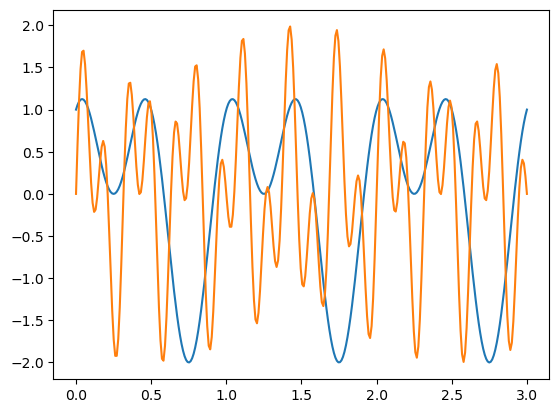

In [21]:
sig_sum_1 = sig_f1 + sig_f2
sig_sum_2 = sig_f3 + sig_f6_5
sig_sum = torch.row_stack((sig_sum_1, sig_sum_2))
print(sig_sum_1.shape, sig_sum_2.shape, sig_sum.shape)
plt.plot(time, sig_sum.T)

In [74]:
def fft(x):
    # B, N = x.shape
    N = len(x)
    W = torch.exp(torch.ones(1) * -2j * torch.pi / N)# + torch.arange(N))
    # W = torch.tile(W, (B, 1))
    # n = torch.tile(torch.arange(N), (B, 1))
    
    result = []
    for k in range(N):
        X_k = 0
        for n in range(N):
            X_k += x[n] * W ** (k * n)
        result.append(X_k)
    
    return torch.tensor(result)
        

In [76]:
sig_fft = torch.fft.fft(sig_sum, dim=1).T
sig_fft = torch.stack((fft(sig_sum[0]), fft(sig_sum[1]))).T
sig_fft

tensor([[ 1.0000e+00+0.0000e+00j,  4.8122e+00+0.0000e+00j],
        [ 1.0324e+00-3.6251e-01j,  4.8257e+00-6.1231e-02j],
        [ 1.1491e+00-1.1655e+00j,  4.8666e+00-1.3033e-01j],
        [ 6.0324e+00-1.4961e+02j,  4.9366e+00-2.1744e-01j],
        [ 1.7149e+00+1.8086e+00j,  5.0395e+00-3.3889e-01j],
        [ 3.1682e+00+1.1125e+00j,  5.1810e+00-5.2608e-01j],
        [ 1.4981e+02+1.0097e+01j,  5.3728e+00-8.5120e-01j],
        [-2.8690e+00+3.1694e-01j,  5.6416e+00-1.5292e+00j],
        [-1.3362e+00+3.2708e-01j,  6.0968e+00-3.6129e+00j],
        [-8.4042e-01+2.9848e-01j,  2.0138e+01-1.4828e+02j],
        [-5.9896e-01+2.6968e-01j,  5.9535e+00+5.5391e+00j],
        [-4.5785e-01+2.4471e-01j,  6.6841e+00+3.3054e+00j],
        [-3.6636e-01+2.2353e-01j,  7.4149e+00+2.6847e+00j],
        [-3.0291e-01+2.0559e-01j,  8.3272e+00+2.4954e+00j],
        [-2.5663e-01+1.9021e-01j,  9.5588e+00+2.5284e+00j],
        [-2.2163e-01+1.7691e-01j,  1.1334e+01+2.7520e+00j],
        [-1.9446e-01+1.6527e-01j,  1.411

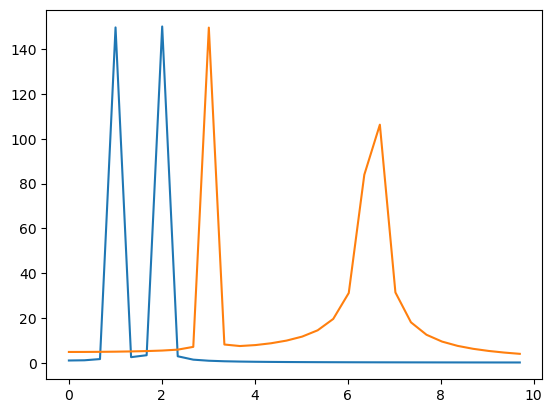

In [69]:
fft_mag = torch.abs(sig_fft)
freq = torch.linspace(0, fs, len(fft_mag))
plot_len = int(len(fft_mag) / (fs)) * 10
plt.plot(freq[:plot_len], fft_mag[:plot_len])

In [78]:
def ifft(fft):
    N = len(fft)
    W = torch.exp(torch.ones(1) * -2j * torch.pi / N)# + torch.arange(N))

    result = []
    for n in range(N):
        X_n = 0
        for k in range(N):
            X_n += fft[k] * W.pow(-n * k)
        result.append(X_n / N)
    
    return torch.tensor(result)

torch.Size([2, 300]) torch.Size([2, 300]) torch.Size([300])


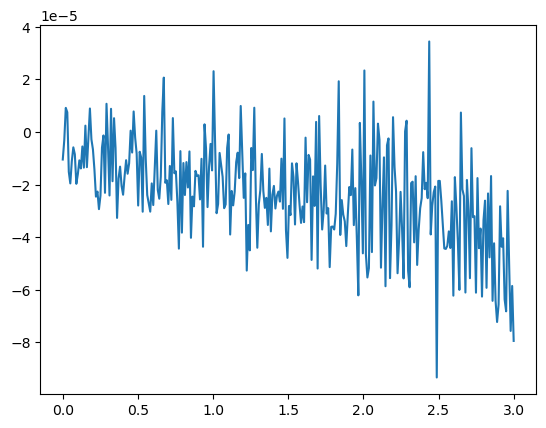

In [87]:
# sig_restored = torch.fft.ifft(sig_fft)
sig_restored = torch.stack((ifft(sig_fft[:, 0]), ifft(sig_fft[:, 1])))
print(sig_restored.shape, sig_sum.shape, time.shape)
plt.plot(time, (torch.real(sig_restored) - sig_sum)[1])

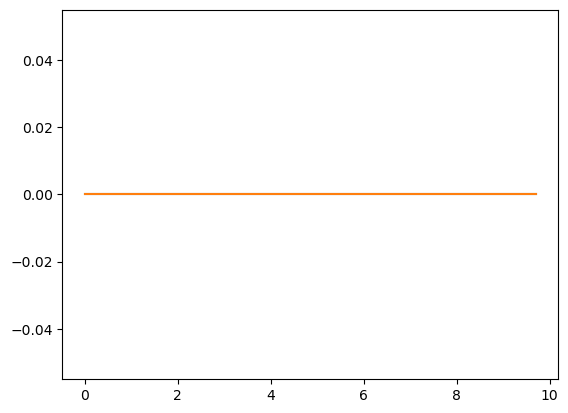

In [9]:
sig_fft[fft_mag < 50] = 0.0
fft_mag = torch.abs(sig_fft)
plt.plot(freq[:plot_len], fft_mag[:plot_len])

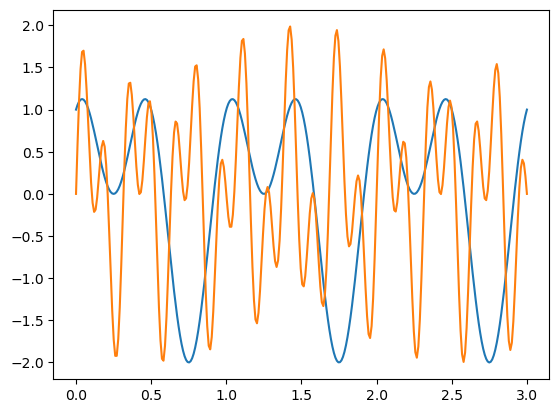

In [10]:
sig_cleared = torch.fft.ifft(sig_fft)
plt.plot(time, torch.real(sig_restored))

/home/kolusask/miniconda3/envs/.idp/lib/python3.10/site-packages/torch/_tensor.py:972: ComplexWarning: Casting complex values to real discards the imaginary part
  return self.numpy().astype(dtype, copy=False)


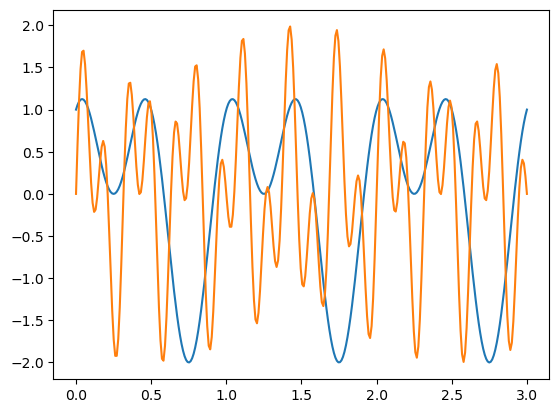

In [11]:
sig_resid = sig_sum - sig_cleared
plt.plot(time, sig_resid)

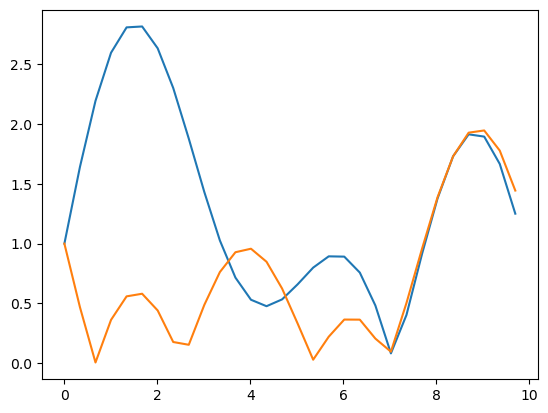

In [12]:
sig_resid_fft = torch.abs(torch.fft.fft(sig_resid))
plt.plot(freq[:plot_len], sig_resid_fft[:plot_len])

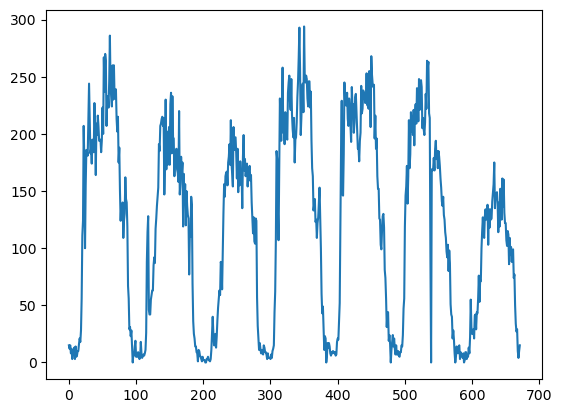

In [13]:
mat_q = torch.real(torch.load(out_path('mat_q.pt')))
mat_q = mat_q[:, SECTION_INDEX]
mat_q_week = crop_q_between(mat_q, READ_START_DATE,
                            READ_END_DATE, PLOT_START_DATE, PLOT_END_DATE)
mat_q_week.shape
plt.plot(mat_q_week)

/tmp/ipykernel_108068/3696422278.py:8: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


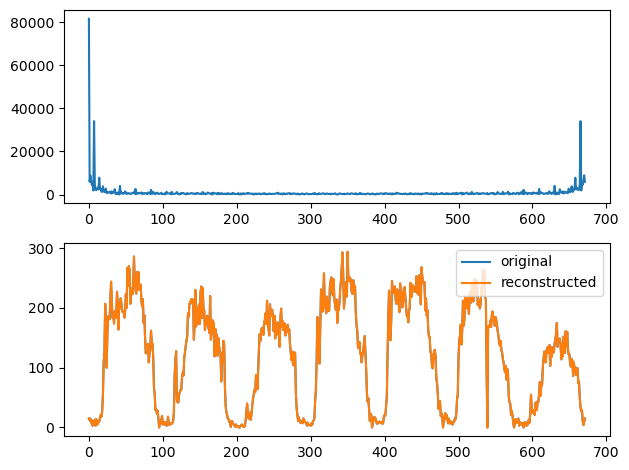

In [14]:
fft_q = torch.fft.fft(mat_q_week)
fig, axes = plt.subplots(2, 1)
axes[0].plot(torch.abs(fft_q))
axes[1].plot(mat_q_week, label='original')
axes[1].plot(torch.abs(torch.fft.ifft(fft_q)), label='reconstructed')
axes[1].legend()
fig.tight_layout()
fig.show()

In [15]:
restored = torch.fft.ifft(fft_q)
def mae(a, b):
    return torch.mean(torch.abs(a - b))
print(mae(mat_q_week, torch.abs(restored)))
print(mae(mat_q_week, torch.real(restored)))

tensor(8.3992e-06)
tensor(8.3813e-06)


/home/kolusask/miniconda3/envs/.idp/lib/python3.10/site-packages/torch/_tensor.py:972: ComplexWarning: Casting complex values to real discards the imaginary part
  return self.numpy().astype(dtype, copy=False)


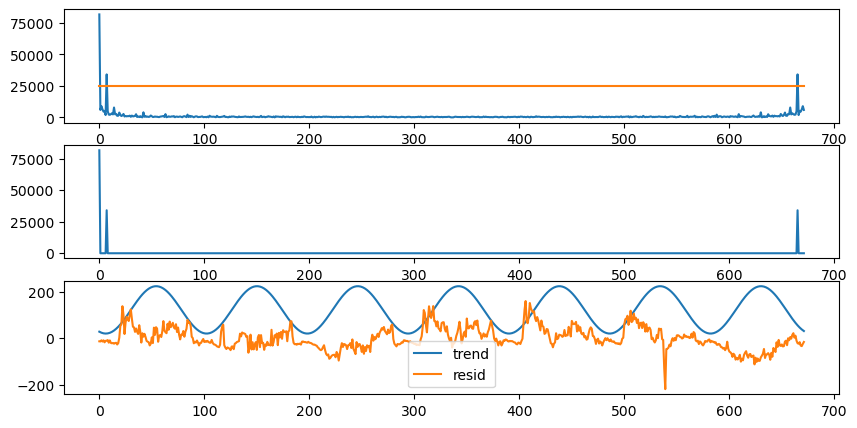

In [20]:
threshold = 25000
fft_q_trend = fft_q.clone()
fft_q_trend[torch.abs(torch.real(fft_q_trend)) < threshold] = 0.0
mat_q_trend = torch.real(torch.fft.ifft(fft_q_trend))
mat_q_resid = mat_q_week - mat_q_trend
fig, axes = plt.subplots(3, 1, figsize=(10, 5))
axes[0].plot(torch.abs(fft_q))
axes[0].plot(torch.ones_like(fft_q_trend) * threshold)
axes[1].plot(torch.abs(fft_q_trend))
axes[2].plot(mat_q_trend, label='trend')
axes[2].plot(mat_q_resid, label='resid')
plt.legend()
plt.show()